In [3]:
# Montaje del drive
from google.colab import drive
drive.mount('/content/drive')

# Importamos el dataset limpio
import pandas as pd
ruta_archivo = '/content/drive/MyDrive/PROYECTOII/Dataset_Nuevo.csv'
df = pd.read_csv(ruta_archivo)

# Verificamos que se cargó correctamente
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras 5 filas:")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dimensiones del dataset: (10000, 12)

Primeras 5 filas:


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,2,-1.225848,-0.911583,1,1,0.021886,1,False,False,False
1,-0.440036,0.198164,1,0.117350,-0.911583,0,1,0.216534,0,False,True,False
2,-1.536794,0.293517,8,1.333053,2.527057,1,0,0.240687,1,False,False,False
3,0.501521,0.007457,1,-1.225848,0.807737,0,0,-0.108918,0,False,False,False
4,2.063884,0.388871,2,0.785728,-0.911583,1,1,-0.365276,0,False,True,False


Precisión en entrenamiento: 92.09%
Precisión en prueba: 84.50%
Promedio de precisión: 88.29%
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90      2389
           1       0.61      0.69      0.64       611

    accuracy                           0.84      3000
   macro avg       0.76      0.79      0.77      3000
weighted avg       0.85      0.84      0.85      3000



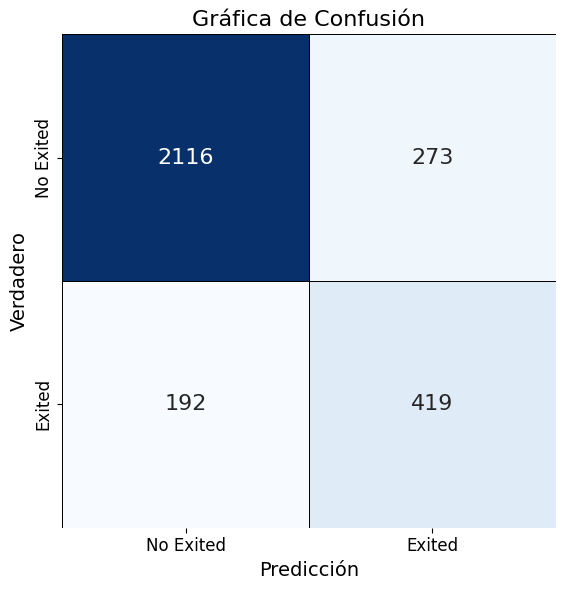

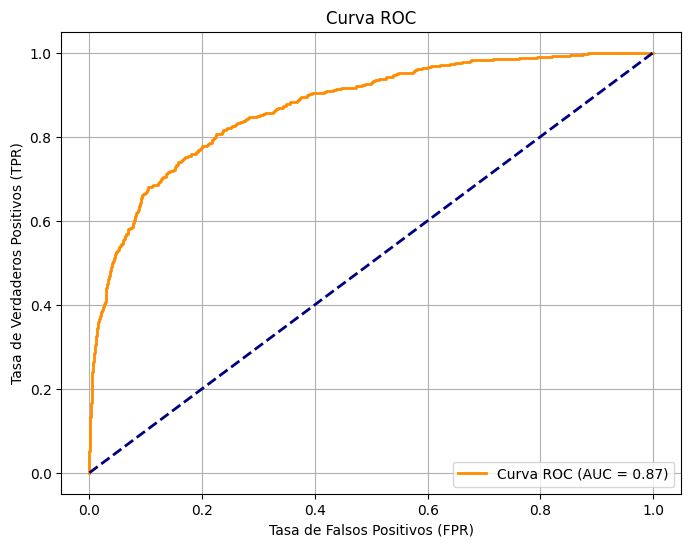

<ipython-input-4-e15194439522>:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")


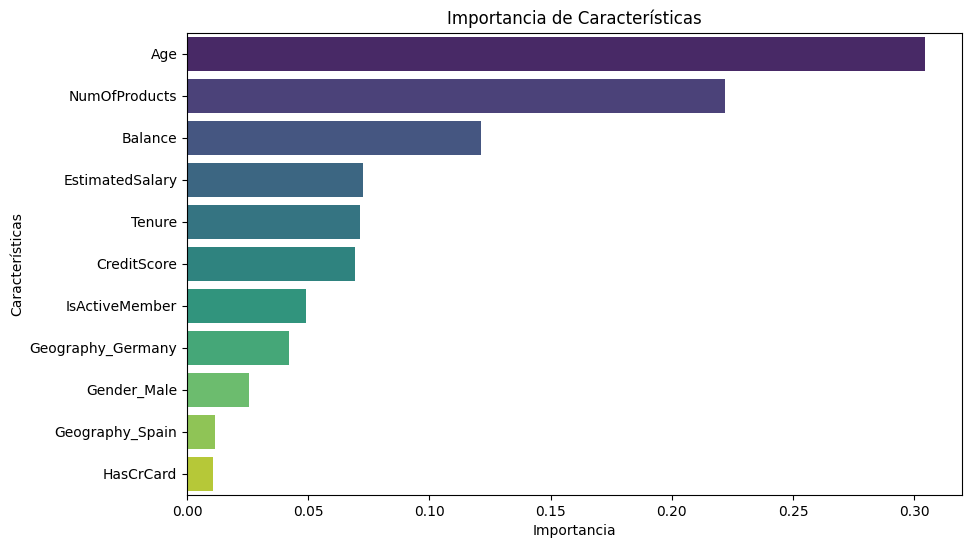

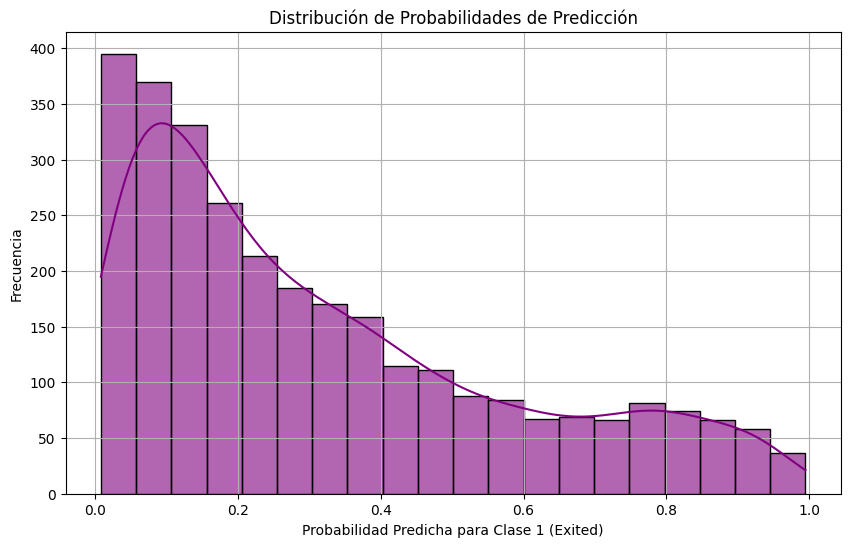

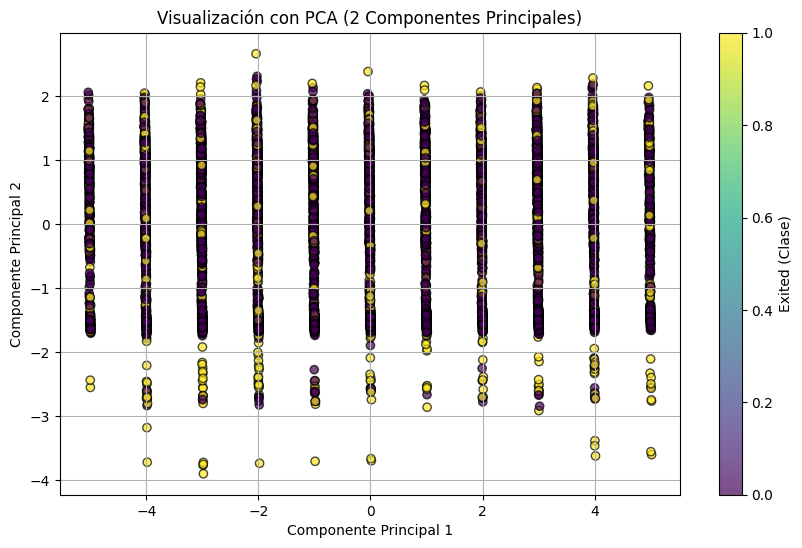

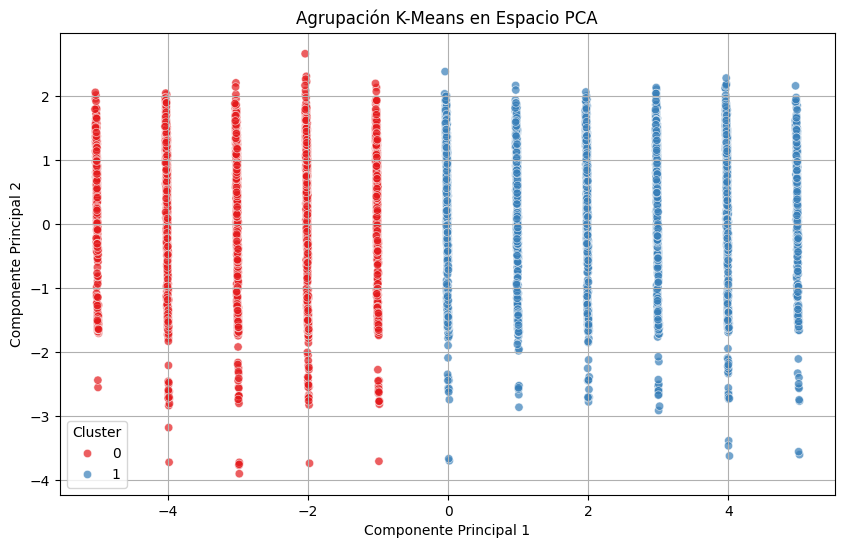

Modelo exportado correctamente.


In [4]:
# Importar librerías adicionales para técnicas no supervisadas
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import numpy as np
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

# Cargar dataset
dataset_path = '/content/drive/MyDrive/PROYECTOII/Dataset_Nuevo.csv'  # Ruta de tu dataset
df = pd.read_csv(dataset_path)

# Separar características (X) y variable objetivo (y)
X = df.drop(columns=['Exited'])
y = df['Exited']

# Preprocesamiento y balanceo de clases
smote = SMOTE(random_state=42)
scaler = StandardScaler()

# Modelo base ajustado manualmente
rf = RandomForestClassifier(
    n_estimators=300,           # Más árboles para estabilidad
    max_depth=15,               # Reducir complejidad para generalizar mejor
    min_samples_split=10,       # Divisiones mínimas más altas
    min_samples_leaf=5,         # Hojas mínimas más grandes
    class_weight='balanced',    # Balance automático de clases
    bootstrap=True,
    random_state=42
)

# Pipeline con SMOTE y escalado
pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('smote', smote),
    ('rf', rf)
])

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Evaluar en el conjunto de entrenamiento
train_accuracy = pipeline.score(X_train, y_train)
print(f"Precisión en entrenamiento: {train_accuracy:.2%}")

# Evaluar en el conjunto de prueba
test_accuracy = pipeline.score(X_test, y_test)
print(f"Precisión en prueba: {test_accuracy:.2%}")

# Promedio de precisiones
average_accuracy = (train_accuracy + test_accuracy) / 2
print(f"Promedio de precisión: {average_accuracy:.2%}")

# Predicciones y probabilidades
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilidad para clase positiva

# Reporte de clasificación
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))

# Matriz de Confusión (sin modificaciones adicionales)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 16}, linewidths=0.5, linecolor='black', square=True)

plt.title("Gráfica de Confusión", fontsize=16)
plt.xlabel("Predicción", fontsize=14)
plt.ylabel("Verdadero", fontsize=14)
plt.xticks(ticks=[0.5, 1.5], labels=["No Exited", "Exited"], fontsize=12)
plt.yticks(ticks=[0.5, 1.5], labels=["No Exited", "Exited"], fontsize=12)
plt.grid(False)  # Eliminar cuadrícula extra
plt.tight_layout()

# Mostrar gráfico
plt.show()

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal de referencia
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Importancia de Características
rf_model = pipeline.named_steps['rf']  # Extraer el modelo Random Forest
importances = rf_model.feature_importances_
feature_names = X.columns

# Ordenar por importancia
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")
plt.title("Importancia de Características")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()

# Distribución de Probabilidades de Predicción
plt.figure(figsize=(10, 6))
sns.histplot(y_proba, bins=20, kde=True, color='purple', alpha=0.6)
plt.title("Distribución de Probabilidades de Predicción")
plt.xlabel("Probabilidad Predicha para Clase 1 (Exited)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# Visualización con PCA (Reducción de Dimensionalidad)
pca = PCA(n_components=2)  # Reducimos a 2 dimensiones para graficar
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7, edgecolor='k')
plt.title("Visualización con PCA (2 Componentes Principales)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Exited (Clase)")
plt.grid(True)
plt.show()

# Agrupamiento con K-Means en el espacio PCA
kmeans = KMeans(n_clusters=2, random_state=42)  # Dos grupos (Exited=0, Exited=1)
kmeans_labels = kmeans.fit_predict(X_pca)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='Set1', alpha=0.7)
plt.title("Agrupación K-Means en Espacio PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster", loc="best")
plt.grid(True)
plt.show()

# Exportar modelo
joblib.dump(pipeline, '/content/drive/MyDrive/PROYECTOII/MODELO.pkl')  # Guardar el modelo
print("Modelo exportado correctamente.")